## Initialization

### Import packages

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F
from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm

#from ENV import KYenv
from ENV import DHenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

### Initiliaze environments

In [3]:
test_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])

test_env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = test_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def gen_env(seed, enb_num, ue_num, min_dis):
    
#     breakpoint()
    set_seed(seed)
    bound_len = np.sqrt(400 * enb_num).astype(int)
    min_dis = int(bound_len / 4)
    enb_pos = torch.zeros(enb_num, 2) - 100
    for i in range(enb_num):
        while True:
            cur_pos = torch.rand(1, 2) * torch.Tensor([bound_len,bound_len])
            dists = torch.sqrt(torch.sum((enb_pos - cur_pos)**2, axis = 1))
#             breakpoint()
            if (dists > min_dis).all():
                enb_pos[i] = cur_pos
                break
    ues_pos = torch.rand(ue_num, 2) * torch.Tensor([bound_len, bound_len])
    enbs = torch.hstack([torch.zeros(enb_num,1) + 10, enb_pos])
#     breakpoint()
    env = Env(border=torch.Tensor([bound_len, bound_len]),
          enbs = enbs,
          ues = ues_pos,
          noise = 10**(-11.5),
          rw = 0.02
          )
    return env

# random seeds: 0, 10, 20
# Env settings: 
# 5, 12
# 6, 15
# 7, 18
# 8, 20
# 9, 23
# 10, 25



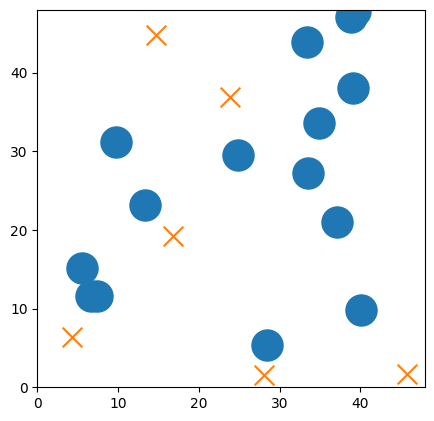

In [7]:
def draw(env, size_on=True, serve_on=True):
        # draw UEs position
    plt.figure(dpi=100, figsize=[5, 5])
    plt.xlim(0, env.border[0])
    plt.ylim(0, env.border[1])
    t_ues = env.ues_pos
    if size_on:
        t_size = env.MA_rate.numpy()
    else:
        t_size = 5

#     print(t_size.shape, t_ues.shape)

    plt.scatter(t_ues[:, 0], t_ues[:, 1], s = np.transpose(t_size * 100))

    if serve_on:
       plt.scatter(env.enbs_pos[:,0],env.enbs_pos[:,1],marker="x",s = 200)
    plt.show()
    
draw(env,False)

In [48]:
obs = []
for j in range(env.n_enbs):
    obs.append(env.get_agent_obs(j))
obs = torch.stack(obs, dim=0)
obs = torch.flatten(obs)
obs.shape

torch.Size([160])

### Initialize models

In [5]:

# enable cuda in training
cuda_flag = True
map_dict = {
    5: 12,
    6: 15,
    7: 18,
    8: 20,
    9: 23,
    10: 25,

}
n = 9
seed = 0
n_ue = map_dict[n]
inter_file_name = f'AP{n}UE{n_ue}Act5_Seed{seed}_Individual.pkl'
env = gen_env(seed, n, n_ue, 10)
num_obs = 16 * n
num_acts = 5 ** n
# initialize learner
controller = DRQN_Agent(input_shape=num_obs, n_actions=num_acts) #n_actions = 6 * 5, input_shape = 11
controller.save('models/' + inter_file_name)
controller.cuda()
meta_controller = deepcopy(controller)
learner = QLearner(controller,device="cuda",batch_size=8,num_feats=num_obs)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=num_obs, n_actions=num_acts) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0

### Training

In [ ]:
import copy
# Defining hyperparams
niterations = 300
max_inner_iter = 64
max_test_iter = 500
outerstepsize0 = 1
k = 0
results_dict = {"loss": None,
               "reward": None}
best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
lr = 5e-4
learner.set_sgd(lr)
pbar = tqdm(range(niterations))
r_history, loss_history = [], []
for iteration in pbar:
    env.reset()
    inner_step = 0
    if (iteration + 1) % 100 == 0:
        lr = lr/2
        learner.set_sgd(lr)
    losses = []
    for inner_iter in range(max_inner_iter):
        total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
        obs = []
#         breakpoint()
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        cur_obs = obs.reshape(1,num_obs).cuda()
        controller.init_hidden(1)
        action,q = controller.get_action(cur_obs, 0.3 * (1-iteration/niterations))
        act = decode_act(action,n,5)
        s_t1,r = env.step(act)
        s_t1 = torch.flatten(s_t1)
        controller.init_hidden(512)
        loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
        if loss is not None:
            losses.append(loss.item())
        
    learner._update_targets()
    # Save the results
    if losses != []:
        loss_history.append(np.mean(losses))
    # save and update the test controller
#     breakpoint()
#     controller.save('models/' + inter_file_name)
    test_controller.load_state(controller)
    env.reset()
    reward = 0
    for test_iter in range(max_test_iter):
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
#         breakpoint()
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        action,_ = test_controller.get_action(
            torch.reshape(obs,(1,num_obs)).cuda(), 0.0)
        act = decode_act(action, n, 5)
        s_t1,r = env.step(act)
        reward += (1 - gamma) * (r - reward)
    r_history.append(reward.item())
    pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item():.2f}")
    if reward.item() > best and iteration > 10:
        best = reward.item()
        print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
        test_controller.save(f"./models/drqn_best_centralized{n}_env{k}.pkl")
    if (iteration + 1) % 50 == 0:
        plt.plot(r_history)
        plt.show()

        plt.plot(loss_history)
        plt.show()
        results_dict["loss"] = loss_history
        results_dict["reward"] = r_history
        with open(f"./results/env_{k}_centralized_{n}_results.pkl", "wb") as file:
            pickle.dump(results_dict, file)
        

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Current best 15.00 at iteration 11! Saving.... 


In [6]:
# heuristic test

gamma = 0.98

rl = []

pos = torch.tensor([[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]])

c = 0
c0 = 0

for _ in range(2):
    obs = env.reset()
    r = 0

    for t in range(500):
        # 4, 5, 3
        action = []
        for i in range(n):
            temp = obs[i]
            dis = ((temp[:, 1:3])**2).sum(-1)
            inds = torch.argsort(dis)
            for j in inds:
                if temp[j, -1] < 3.:
                    break
            if temp[j, -1] >= 3.:
                j = torch.tensor(5)
            action.append(j.view(1))
        action = torch.cat(action)

        obs, reward = env.step(action)
        r += (1 - gamma) * (reward - r)
        #print(r)
        
        c += 1
        plan = torch.tensor(env.plan).tolist()
        if len(plan) == len(set(plan)):
            c0 += 1
    print(r)
    rl.append(r)

tensor(43.4940)
tensor(43.7055)


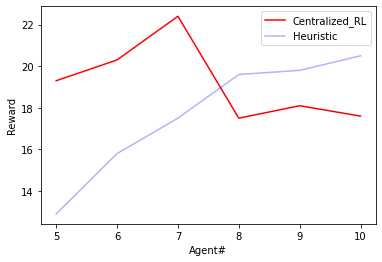

In [20]:
centralized_dist = [19.3, 20.3, 22.4, 17.5, 18.1, 17.6]
heuristic = [12.9, 15.8, 17.5, 19.6, 19.8, 20.5]
env_num = [5,6,7,8,9,10]

plt.figure()

plt.plot(env_num,centralized_dist,alpha=1,label="Centralized_RL",color="r")
plt.plot(env_num,heuristic,alpha=0.3,label="Heuristic",color="b")
plt.xlabel("Agent#")
plt.ylabel("Reward")
plt.legend()
plt.show()

### Draw results

In [16]:
with open("./results/env_0_results.pkl", "rb") as file:
            result = pickle.load(file)

In [18]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import os 
import sys
import matplotlib.pyplot as plt

In [62]:
from glob import glob
dirs = glob("./results/*_results*.pkl")
dirs

['./results/env_5_centralized_results.pkl',
 './results/env_0_centralized_results.pkl',
 './results/env_6_centralized_results.pkl']

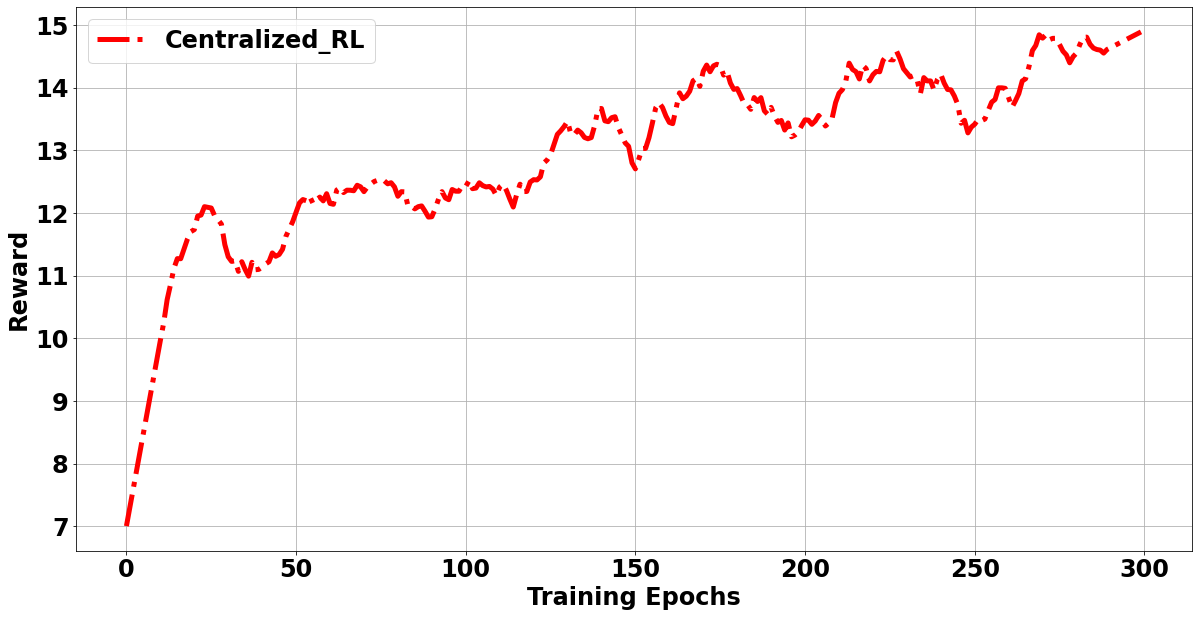

In [63]:
import json
import matplotlib
from scipy.signal import savgol_filter

figure_map= {
    "MARL":["b", "-"],
    "Centralized_RL":["r","-."],
    "Heuristic_baseline":["g",":"]
    
}

font = {'weight' : 'bold',
        'size'   : 24}

results = {}

for i,d in enumerate(dirs):
#     breakpoint()
    d = dirs[i]
    label = dirs[i].split("_")[-2]
    
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if label not in results:
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            results[label] += np.array(r)
        else:
            r = np.array(r)
            results[label] += np.array(r)

plt.figure(figsize = (20,10))
if label == "centralized":
    label_n = "Centralized_RL"
plt.plot(savgol_filter(results[label], 21, 1)/len(dirs),c = figure_map[label_n][0],lw=5 ,ls=figure_map[label_n][1], label = label_n)
plt.xlabel("Training Epochs", fontsize=24, weight="bold")
plt.ylabel("Reward", fontsize=24, weight="bold")
matplotlib.rc('font', **font)
plt.grid()
plt.legend()

